<h2>Forecasting</h2>

In this module, we discuss the forecasting task. This is a special case of the regression task - the prediction target (label) is numeric, however, we also have the time correlation among the instances in the data. The data for this task is usually referred to as time series data.

For this module, we use the the daily minimum temperature data. Recall, this data consists of the daily minimum temperatures from 1981 to 1990 and only has two columns, Date and Temp. The task is to use current/historical data at a date to predict next day's temperature. 

<h3>Loading and Visualizing the Data</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dailytemp = pd.read_csv('daily-min-temperatures.csv')
dailytemp

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


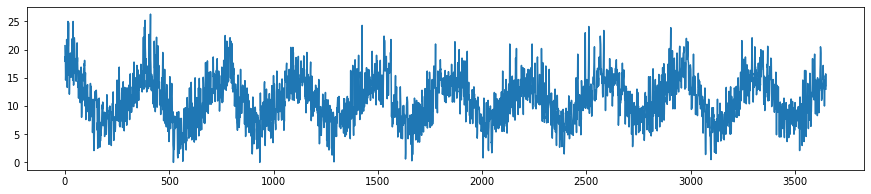

In [6]:
plt.figure(figsize=(15,3))
plt.plot(dailytemp['Temp'])
plt.show()

<h3>Modeling with Regular Regression Models</h3>

Regular regression models like SVM, decision tree, random forest, while not having been designed specifically for data with time correlations, can still be applied to this task. However, we need to manually process the data to the desired format before being able to use them.

<h4>Obtaining Historical Data</h4>

In general, we can obtain historical data by having a moving window, for example, 5. Then, for each day, we use its temparature and the previous four as features. This require some data transformation as below.

In [48]:
dailytemp_series = dailytemp['Temp'].values

In [49]:
window = 5

X = np.array([dailytemp_series[i:i+window].flatten() for i in range(dailytemp_series.shape[0]-window)])
X.shape

(3645, 5)

The label is generated by shifting the original data one time step (one day) ahead

In [50]:
y = dailytemp_series[window:]
y.shape

(3645,)

In [51]:
X

array([[20.7, 17.9, 18.8, 14.6, 15.8],
       [17.9, 18.8, 14.6, 15.8, 15.8],
       [18.8, 14.6, 15.8, 15.8, 15.8],
       ...,
       [10. , 12.9, 14.6, 14. , 13.6],
       [12.9, 14.6, 14. , 13.6, 13.5],
       [14.6, 14. , 13.6, 13.5, 15.7]])

In [53]:
y.reshape(-1,1)

array([[15.8],
       [15.8],
       [17.4],
       ...,
       [13.5],
       [15.7],
       [13. ]])

Split into training, validation, and testing data. Since this is time correlated data, we generally do not want to do a random split. Instead, we use the first 3000 days as training/validation and the rest for testing

In [41]:
trainX = X[:3000]
trainY = y[:3000]
testX = X[3000:]
testY = y[3000:]
trainX.shape, trainY.shape, testX.shape, testY.shape

((3000, 10), (3000,), (640, 10), (640,))

<h3> Modeling </h3>

With the data defined, we can apply regression models like SVR, trees, forests, etc., just like before

<h4>Support Vector Regressor</h4>

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svr = SVR()

param_grid = [{
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel' : ['rbf'],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}]

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='r2')

The finetuned model (note that score is now R2 since we are doing regression):

In [14]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.6117292425247125


And the testing performance 

In [15]:
best_svr = grid_search.best_estimator_
best_svr.score(testX, testY)

0.6571543472615495

<h4>Decision Tree Regressor</h4>

In [16]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

param_grid = [{
    'max_depth': [3,4,5,6],
    'max_features' : [4],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(dtr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [3, 4, 5, 6], 'max_features': [4],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40]}],
             return_train_score=True, scoring='r2')

In [17]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 40, 'min_samples_split': 2}
0.576951940249534


In [18]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.6274126871087433

<h4>Random Forest Regressor</h4>

In [19]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

param_grid = [{
    'n_estimators' : [5, 10, 20, 50],
    'max_depth': [3,4,5],
    'max_features' : [4],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [3, 4, 5], 'max_features': [4],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40],
                          'n_estimators': [5, 10, 20, 50]}],
             return_train_score=True, scoring='r2')

In [20]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 40, 'min_samples_split': 30, 'n_estimators': 50}
0.605000533973142


In [21]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.653835568783887

<h4>Neural Network Regressor</h4>

In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

n_features = window

param_grid = [{
    'hidden_layer_sizes' : [[n_features,n_features],                       #two hidden layer with n_features neurons
                            [n_features,n_features,n_features],            #three hidden layer with n_features neurons 
                            [n_features//2,n_features//2],                 #two hidden layer with n_features/2 neurons
                            [n_features//2,n_features//2,n_features//2],   #three hidden layer with n_features/2 neurons
                            [n_features*2,n_features*2],                   #two hidden layer with n_features*2 neurons
                            [n_features*2,n_features*2,n_features*2]],     #three hidden layer with n_features*2 neurons
    'alpha' : [0.001, 0.01, 0.1, 1, 10]                                    #regularization terms
}]

mlp = MLPRegressor(max_iter=2000)

grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

C:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maxi

GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=1000),
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10],
                          'hidden_layer_sizes': [[5, 5], [5, 5, 5], [2, 2],
                                                 [2, 2, 2], [10, 10],
                                                 [10, 10, 10]]}],
             return_train_score=True, scoring='r2')

Best training model:

In [24]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'alpha': 0.1, 'hidden_layer_sizes': [5, 5, 5]}
0.6096435067355621


In [25]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.650244442475832

<h3>Using Longer Historical Data</h3>

For this kind of problem, window size can be considered a hyperparameter. Different window size may yield different model performances. Longer historical data is potentially better, however, not all the times, and the improvement might be marginally compared to the increase in model complexity. Furthermore, the larger the window size, the less training data we have. So, this parameter should be selected carefully.

In [26]:
window = 10

X = np.array([dailytemp_series[i:i+window].flatten() for i in range(dailytemp_series.shape[0]-window)])
X.shape

(3640, 10)

In [27]:
y = dailytemp_series[window:] #the target is the close price beginning from the 2nd day in the data
y.shape

(3640,)

Split into training, validation, and testing data. Since this is time correlated data, we do not want to do a random split. Instead, we use the first 6000 days as training, next 600 days as validation, and the rest for testing

In [28]:
trainX = X[:3000]
trainY = y[:3000]
testX = X[3000:]
testY = y[3000:]

Fitting models are similar like before

<h4> Using Longer Historical Data</h4>
<h5> Support Vector Regressor </h5>

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svr = SVR()

param_grid = [{
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel' : ['rbf'],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}]

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='r2')

The finetuned model (note that score is now R2 since we are doing regression):

In [30]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.6174250358406701


And the testing performance 

In [31]:
best_svr = grid_search.best_estimator_
best_svr.score(testX, testY)

0.6717075642334749

<h4>Decision Tree Regressor</h4>

In [32]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

param_grid = [{
    'max_depth': [3,4,5,6],
    'max_features' : [4],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(dtr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [3, 4, 5, 6], 'max_features': [4],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40]}],
             return_train_score=True, scoring='r2')

In [33]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 30, 'min_samples_split': 20}
0.5524730147427556


In [34]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.6113637528281117

<h4>Random Forest Regressor</h4>

In [35]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

param_grid = [{
    'n_estimators' : [5, 10, 20, 50],
    'max_depth': [3,4,5],
    'max_features' : [4],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [3, 4, 5], 'max_features': [4],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40],
                          'n_estimators': [5, 10, 20, 50]}],
             return_train_score=True, scoring='r2')

In [36]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 50}
0.6068743949342206


In [37]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.6644664549395594

<h4>Neural Network Regressor</h4>

In [38]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

n_features = window

param_grid = [{
    'hidden_layer_sizes' : [[n_features,n_features],                       #two hidden layer with n_features neurons
                            [n_features,n_features,n_features],            #three hidden layer with n_features neurons 
                            [n_features//2,n_features//2],                 #two hidden layer with n_features/2 neurons
                            [n_features//2,n_features//2,n_features//2],   #three hidden layer with n_features/2 neurons
                            [n_features*2,n_features*2],                   #two hidden layer with n_features*2 neurons
                            [n_features*2,n_features*2,n_features*2]],     #three hidden layer with n_features*2 neurons
    'alpha' : [0.001, 0.01, 0.1, 1, 10]                                    #regularization terms
}]

mlp = MLPRegressor(max_iter=1000)

grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=1000),
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10],
                          'hidden_layer_sizes': [[10, 10], [10, 10, 10], [5, 5],
                                                 [5, 5, 5], [20, 20],
                                                 [20, 20, 20]]}],
             return_train_score=True, scoring='r2')

Best training model:

In [39]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'alpha': 10, 'hidden_layer_sizes': [5, 5, 5]}
0.6185157400108672


In [40]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.6658716568290162